In [1]:
import torch
# import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data si este procesat in notebook-ul data/process_data.ipynb pentru usurinta.

Codul se poate rula integral prin optiunea "Run All" a notebook-ului

In [2]:
def load_data(path):
    date_salvate = torch.load(path,weights_only=True)
    x_train = date_salvate['train_data']
    x_test = date_salvate['test_data']
    y_train = date_salvate['train_labels']
    y_test = date_salvate['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [3]:
def normalize_data(x_train,x_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    return x_train,x_test


In [4]:
x_train,x_test,y_train,y_test = load_data('../../data/date_logistic_regression.pth')
x_train,x_test= normalize_data(x_train,x_test)
x_train,x_test,y_train,y_test= x_train[:1000],x_test[:700],y_train[:1000],y_test[:700]
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul,
#  deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [5]:
class LogisticRegressionFromScratch:
    def __init__(self, n_features, learning_rate=0.1, weight_decay=0.1):
        # self.bound = np.sqrt(3/n_features)
        self.weight = torch.tensor([0.00]*16)
        # self.weight =  torch.tensor(np.random.uniform(-self.bound, self.bound, size=n_features))
        self.bias = torch.tensor([0.000])
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._delta_w = 0
        self._delta_b = 0
       

    def forward(self, x_data):
    # enc_x este un batch de date, shape : (b, n_features)
        dot = x_data @ self.weight +  self.bias
        sigmo = torch.sigmoid(dot)
        return sigmo
  
    
    def backward(self, enc_x, enc_out, enc_y):
        batch_size = len(enc_x)
        delta_y = [(out - y) for out, y in zip(enc_out, enc_y)]
        delta_w = [ x * dy for dy, x in zip(delta_y, enc_x)]
        self._delta_w = sum(delta_w) * (2 / batch_size)
        self._delta_b = sum(delta_y) * (2/batch_size)

        
    def update_parameters(self):
        self._delta_w *= self.learning_rate
        self._delta_w += self.weight_decay * self.weight
        self.weight -= self._delta_w
        
        self.bias -= self._delta_b * self.learning_rate
        self._delta_w = 0
        self._delta_b = 0
   


In [6]:
def save_model(model, file_path):
    pickle.dump(model, open(file_path, "wb"))

Antrenarea modelului are trei pasi esentiali:


1. **Forward**: pentru regresia logistica, se aplica o combinatie liniara a intrarii urmată de funcția de activare sigmoid:

$$
z = \mathbf{w}^\top \mathbf{x} + b
$$

Probabilitatea estimată este dată de funcția **sigmoid**:

$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

2. **Backward**: functia de pierdere pentru regresia logistica este **binary cross-entropy**:

$$
\mathcal{L} = -\frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

Gradientii se calculeaza astfel:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i) \cdot \mathbf{x}_i
$$

$$
\frac{\partial \mathcal{L}}{\partial b} = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)
$$

3. **Actualizarea parametrilor**: se foloseste o rata de invatare $\eta$ pentru a ajusta parametrii:

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{w}}
$$

$$
b \leftarrow b - \eta \cdot \frac{\partial \mathcal{L}}{\partial b}
$$


epoch:  20%|██        | 4/20 [00:00<00:00, 33.55it/s]

Epoch 1, Loss: 0.6644941568374634
Epoch 2, Loss: 0.5730871558189392
Epoch 3, Loss: 0.5205616354942322
Epoch 4, Loss: 0.48896917700767517
Epoch 5, Loss: 0.4675493538379669


epoch:  65%|██████▌   | 13/20 [00:00<00:00, 28.57it/s]

Epoch 6, Loss: 0.45327579975128174
Epoch 7, Loss: 0.4436244070529938
Epoch 8, Loss: 0.4370950758457184
Epoch 9, Loss: 0.43161851167678833
Epoch 10, Loss: 0.42817333340644836
Epoch 11, Loss: 0.4250712990760803
Epoch 12, Loss: 0.4236571192741394
Epoch 13, Loss: 0.4217424988746643
Epoch 14, Loss: 0.42106133699417114


epoch: 100%|██████████| 20/20 [00:00<00:00, 32.42it/s]


Epoch 15, Loss: 0.4192920923233032
Epoch 16, Loss: 0.41861796379089355
Epoch 17, Loss: 0.41797012090682983
Epoch 18, Loss: 0.4170197546482086
Epoch 19, Loss: 0.417013943195343
Epoch 20, Loss: 0.4162757098674774


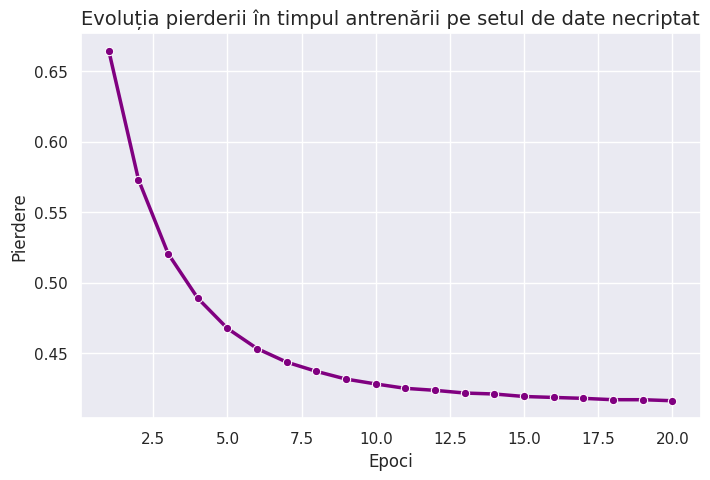

Antrenarea modelului pe date necriptate a durat:1.06307428899999933947 secunde


In [6]:
lo_r_model = LogisticRegressionFromScratch(n_features=x_train.shape[1])
t_start = time.perf_counter()
batch_size = 512
epochs = 20
bce_loss = torch.nn.BCELoss()
loss_list =[]
for epoch in tqdm(range(epochs),desc="epoch"):
    indices = np.random.permutation(x_train.shape[0])
    epoch_data = x_train[indices]
    epoch_targets = y_train[indices].float()  
    predictions = torch.tensor([])
    for batch in range(0, len(epoch_data),batch_size):
        batch_data = epoch_data[batch: batch+batch_size]
        batch_targets = epoch_targets[batch: batch+batch_size]
        batch_out = lo_r_model.forward(batch_data)
        lo_r_model.backward(batch_data, batch_out, batch_targets)
        lo_r_model.update_parameters()
        predictions= torch.cat((predictions , batch_out), dim=0) 
    loss =  bce_loss(predictions, epoch_targets.squeeze())
    loss_list.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss}")
loss_list = [loss.item() for loss in loss_list]  
sns.set_theme(style="darkgrid", palette="pastel")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, epochs + 1), y=loss_list, marker='o', linewidth=2.5, color="Purple")
plt.xlabel('Epoci', fontsize=12)
plt.ylabel('Pierdere', fontsize=12)
plt.title('Evoluția pierderii în timpul antrenării pe setul de date necriptat', fontsize=14)
plt.savefig('../../plots/logistic_regression/lo_r_loss_curve_training_on_clear_data.png')
plt.show()

t_end = time.perf_counter()

print(f"Antrenarea modelului pe date necriptate a durat:{(t_end - t_start):.20f} secunde")

# save_model(lo_r_model,'lo_r_trained_on_clear_data.pkl')




In [96]:
def metrics_on_clear_data(model, x, y):
    t_start = time.perf_counter()
    out = model.forward(x)
    print(type(out))
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")
    correct = torch.abs(y - out.reshape(-1, 1)) < 0.5
    correct= correct.float().mean()
    print(f"Acuratetea pe setul de date necriptate: {correct}")
    binary_preds = (np.array(out) > 0.5).astype(int)
    cm = confusion_matrix(y_test, binary_preds,  labels=[0, 1])
    plt.figure(figsize=(8,6))
    sns.set_style("dark")
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=['Fără risc', 'Cu risc crescut'], yticklabels=[ 'Fără risc', 'Cu risc crescut'],linewidth=.5)
    plt.xlabel('Predicții')
    plt.ylabel('Valori reale')
    plt.title('Model antrenat pe date clare predictii pe date clare')
    plt.legend(title=f'Acuratete: {correct:.4f}', title_fontsize=12)
    plt.savefig('../../plots/logistic_regression/lo_r_trained_on_clear_data_confusion_matrix_on_clear_data.png')
    plt.show()
    return  correct,binary_preds


<class 'torch.Tensor'>
Predictiile pe testul de date necriptate au durat:0.00096761400027389755 secunde
Acuratetea pe setul de date necriptate: 0.9228571653366089


/tmp/ipykernel_2200/1500009064.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'Acuratete: {correct:.4f}', title_fontsize=12)


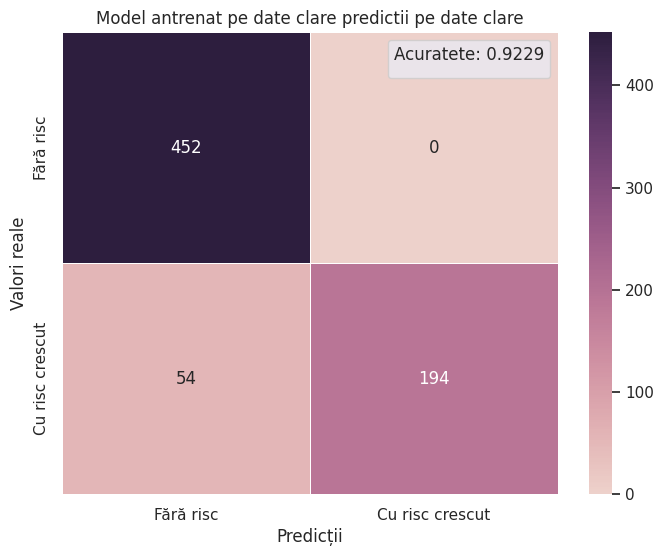

In [97]:
plain_accuracy,binary_preds = metrics_on_clear_data(lo_r_model, x_test, y_test)


In [19]:
_,data_frame_test,_,_ = load_data('../../data/date_logistic_regression.pth')
data_frame_test = data_frame_test[:700]
ages = data_frame_test[:, 0]
gender = data_frame_test[:,1]
gender = np.where(gender == 1, "Bărbat", "Femeie")
df_pred = pd.DataFrame({
    "age": ages,
    "gen": gender,
    "risk": binary_preds 
})

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################


In [20]:
df_pred

,age,gen,risk
0,33.0,Bărbat,0
1,53.0,Femeie,1
2,30.0,Femeie,0
3,50.0,Femeie,1
4,49.0,Bărbat,1
...,...,...,...
695,50.0,Bărbat,1
696,20.0,Bărbat,0
697,49.0,Bărbat,1
698,53.0,Bărbat,1


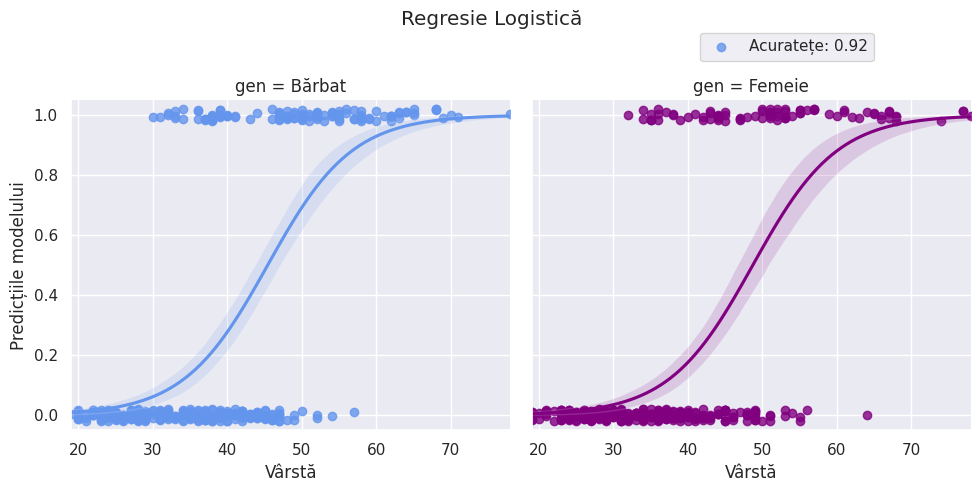

In [55]:
sns.set_theme(style="darkgrid")

palette = dict(Bărbat="#6495ED", Femeie="purple")

g = sns.lmplot(
    x="age", y="risk", col="gen", hue="gen", data=df_pred,
    palette=palette, y_jitter=0.02, logistic=True, truncate=False
)

g.set(xlim=(df_pred["age"].min(), df_pred["age"].max()), ylim=(-0.05, 1.05))
g.set_axis_labels("Vârstă", "Predicțiile modelului")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Regresie Logistică")
g.fig.legend([f"Acuratețe: {plain_accuracy:.2f}"],
             loc='upper left', bbox_to_anchor=(0.7, 0.95),
             ncol=1, frameon=True)
plt.savefig("lo_r_trained_on_clear_data_predictions_on_clear_data.png")
plt.show()


In [26]:
def feature_importance(model, feature_names):
    weights = model.weight

    weights = torch.abs(weights)
    weights = weights / torch.sum(weights)

    sorted_indices = torch.argsort(weights)
    feature_names_sorted = [feature_names[i] for i in sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Purples", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor - model antrenat pe date criptate', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("../../plots/logistic_regression/lo_r_trained_on_clear_data_feature_importance.png")
    plt.show()



['Age', 'Gender', 'Chest Pain', 'High Blood Pressure', 'Irregular Heartbeat', 'Shortness Of Breath', 'Fatigue Weakness', 'Dizziness', 'Swelling Edema', 'Neck Jaw Pain', 'Excessive Sweating', 'Persistent Cough', 'Chest Discomfort', 'Cold Hands Feet', 'Snoring Sleep Apnea', 'Anxiety Doom']


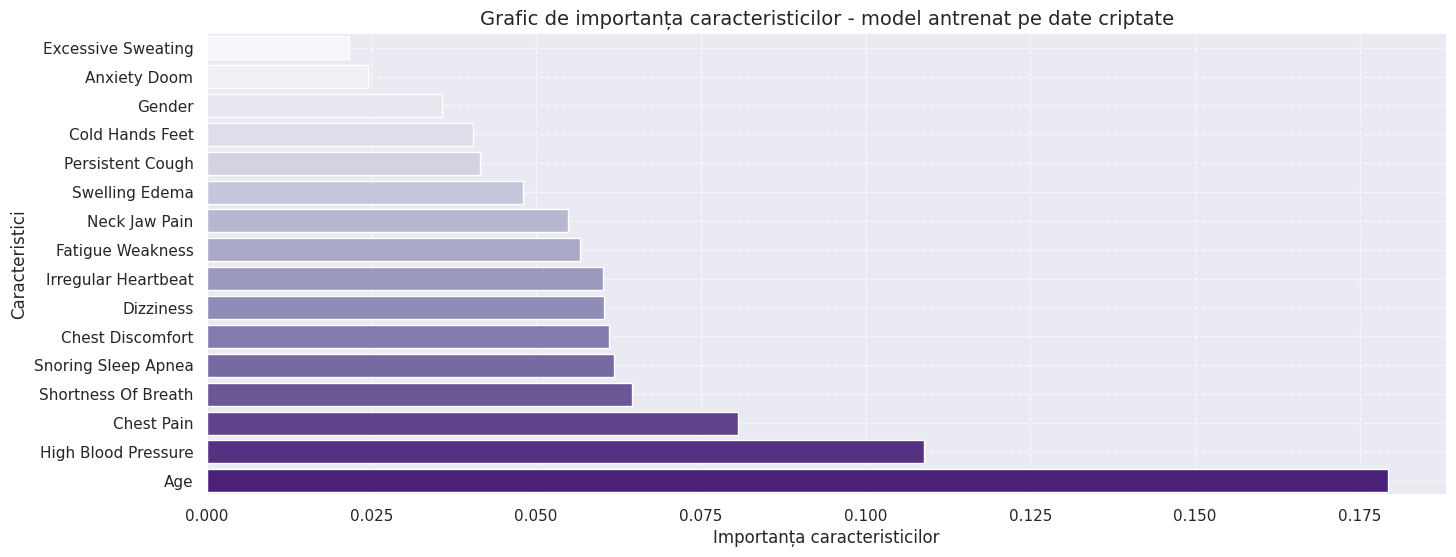

In [28]:
csv = pd.read_csv('../../data/stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk", "nausea_vomiting"])
header = csv.columns.tolist()

formatted_features = [feat.replace('_', ' ').title() for feat in header]
print(formatted_features)
feature_importance(lo_r_model,formatted_features) 

Preziceri pe date criptate

In [29]:
multDepth = 8
scaleModSize = 50
batchSize = len(x_test[1]) #16
parameters = CCParamsCKKSRNS()
parameters.SetMultiplicativeDepth(multDepth)
parameters.SetScalingModSize(scaleModSize)
parameters.SetBatchSize(batchSize)
parameters.SetRingDim(4096)
parameters.SetSecurityLevel(HEStd_NotSet)

cc = GenCryptoContext(parameters)

cc.Enable(PKE)
cc.Enable(KEYSWITCH)
cc.Enable(LEVELEDSHE)
cc.Enable(ADVANCEDSHE)
ring_dim = cc.GetRingDimension()
print(f"Dimensiunea inelului in CKKS {ring_dim}")
security_param= parameters.GetSecurityLevel()
print(f"Parametrul de securitate: {security_param}")
keys = cc.KeyGen()

#asigura ca evaluarea datelor criptate se face fara decriptatea lor
#cheile sunt derivate din secret key
cc.EvalMultKeyGen(keys.secretKey)
cc.EvalSumKeyGen(keys.secretKey)


Dimensiunea inelului in CKKS 4096
Parametrul de securitate: SecurityLevel.HEStd_NotSet


In [30]:
#x_test nu are o forma buna pentru biblioteca openfhe
print(x_test.shape)
x_test_list = x_test[:700].tolist() 
print(x_test_list[:2])
print(type(x_test_list[0]))

torch.Size([700, 16])
[[-0.4856494069099426, -1.00515615940094, -0.4117799401283264, 1.7292275428771973, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.41272860765457153, -0.3342396318912506, 3.038736343383789, -0.343669593334198, 2.4405479431152344, -0.4890051484107971, -0.4168514609336853, -0.33037757873535156], [1.2492173910140991, 0.9948703050613403, -0.4117799401283264, 1.7292275428771973, 3.0457913875579834, 2.0500738620758057, 1.7520751953125, 2.0611891746520996, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, 2.90977144241333, 2.4405479431152344, 2.0449681282043457, -0.4168514609336853, -0.33037757873535156]]
<class 'list'>


In [32]:
def encrypt_vector():
    enc_list=[]
    for x_t_l in tqdm(x_test_list, desc="criptare date"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [33]:
t_start = time.perf_counter()
enc_test_list = encrypt_vector()
t_end = time.perf_counter()
print(f"Criptarea pe setul de date de test a durat {(t_end - t_start):.20f} secunde")

criptare date: 100%|██████████| 700/700 [00:05<00:00, 119.66it/s]

Criptarea pe setul de date de test a durat 5.85430424300000140647 secunde


Pentru a putea aproxima functia sigmoid, openfhe are **cc.EvalLogistic** ce intoarce o aproximare folosind Chebyshev 
Aproximare este valida in anumite intervale, de aceea trebuie sa vedem in ce interval de numere se aseaza datele noastre.

In [75]:
weights = lo_r_model.weight
bias = lo_r_model.bias

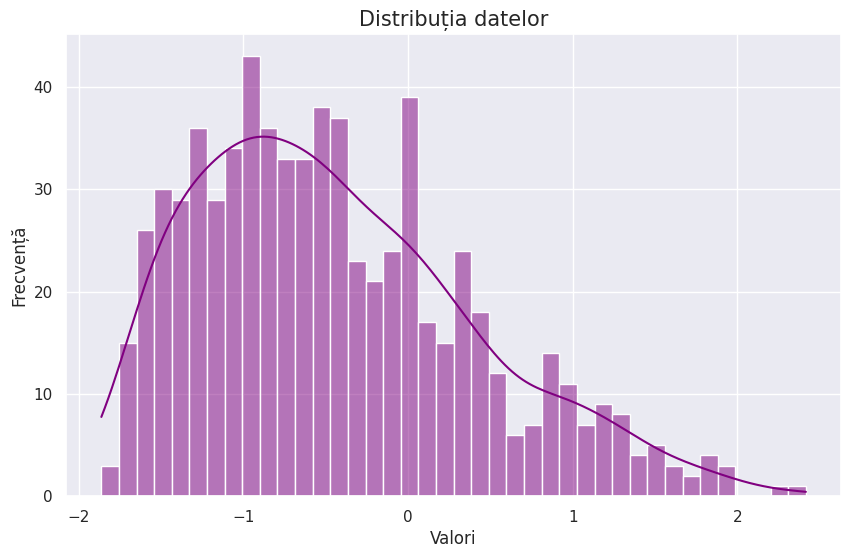

In [90]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
x_plot = x_test @ weights + bias
sns.histplot(x_plot, color='purple', bins=40, kde=True)

plt.title('Distribuția datelor', fontsize=15)
plt.xlabel('Valori', fontsize=12)
plt.ylabel('Frecvență', fontsize=12)
plt.savefig("../../plots/logistic_regression/data_distribution.png")
plt.show()

se observa ca valorile cad intre -2 si 2 in cea mai mare parte, deci un interval de $[-5,5]$ ar trebui sa fie suficient pentru a aproxima bine valorile

In [91]:
def forward_on_encrypted_data(model,enc_x):
    weight = model.weight.tolist()
    bias = model.bias.tolist()
    #encode weight si bias
    encoded_weights = cc.MakeCKKSPackedPlaintext(weight)
    encoded_bias = cc.MakeCKKSPackedPlaintext(bias)
    enc_sum = cc.EvalInnerProduct(enc_x, encoded_weights,16)
    enc_pred = cc.EvalAdd(enc_sum, encoded_bias)
    # print(parameters.GetLevel)
    enc_log = cc.EvalLogistic(enc_pred,-5,5,16)
    return enc_log

In [ ]:
def metrici_date_test_criptate(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in tqdm(enc_x, desc="Predictii"):
        pred = forward_on_encrypted_data(model,e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
    # return enc_list_pred[0]
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    # print(list_pred)
    list_pred = torch.tensor(list_pred)
    
    binary_preds = (np.array(list_pred) > 0.5).astype(int)
    correct = torch.abs(y - list_pred.reshape(-1, 1)) < 0.5
    correct= correct.float().mean()

    print(f"Acuratetea pe datele criptate este: {correct}")
    cm = confusion_matrix(y, binary_preds,  labels=[0, 1])
    plt.figure(figsize=(8,6))
    sns.set_style("dark")
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=['Fără risc', 'Cu risc crescut'], yticklabels=[ 'Fără risc', 'Cu risc crescut'],linewidth=.5)
    plt.xlabel('Predicții')
    plt.ylabel('Valori reale')
    plt.title('Model antrenat pe date clare predictii pe date criptate')
    plt.legend(title=f'Acuratete: {correct:.4f}', titlefontsize=12)
    plt.savefig('../../plots/logistic_regression/lo_r_trained_on_clear_data_confusion_matrix_on_encrypted_data.png')
    plt.show()

    return correct
  
    

Predictii: 100%|██████████| 700/700 [01:48<00:00,  6.43it/s]


Predictiile pe testul de date criptat au durat:108.93672332100004496169 secunde
Decriptarea predictiilor a durat:2.55681067700015773880 secunde
Acuratetea pe datele criptate este: 0.9228571653366089


/tmp/ipykernel_2200/463940520.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'Acuratete: {correct:.4f}', title_fontsize=12)


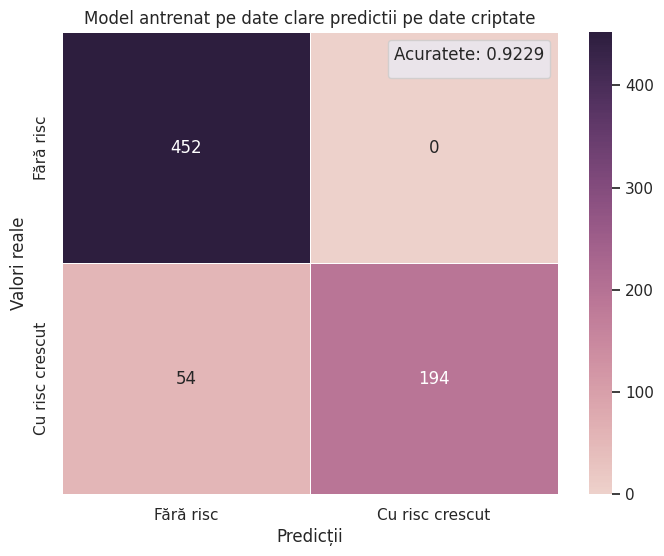

tensor(0.9229)


In [93]:
encrypted_accuracy = metrici_date_test_criptate(lo_r_model,enc_test_list,y_test)
print(encrypted_accuracy)

se vede ca diferenta de precizie este inexistenta intre prezicerile pe date clare si cele pe date criptate

